In [1]:
import glob
import re
import numpy as np
from dictances import bhattacharyya
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
%matplotlib inline

/Users/theman/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def normalization(array):
    max_of_array = np.max(array)
    normlized_array = array/max_of_array
    return normlized_array


#normalizing the array for processing before comparison
def return_normz(arr1):
    normz = []
    for x in arr1:
        z = (x - min(arr1))/(max(arr1) - min(arr1))
        normz.append(z)
    return normz

# softmax to normalize to a probability distribution
def softmax(x):
    e_x = np.exp(x - np.max(x))
    vals = e_x / e_x.sum()
    return vals

# introduce the array in the function
def making_dictionnaries(py_normz):
    value = 0
    string_index =[]
    for i in py_normz:
        value = value + 1
        str_in = "value" + str(value)
        string_index.append(str_in)
    return string_index

        
#Read all the arrayX from the file
def read_input_arrays(file_path='input_arrays.txt'):
    try:
        f = open(file_path, "r")
        file_content=f.read()
        file_array=file_content.split('\n')
        file_array=[item for item in file_array if item.replace(' ','')!='']
    except Exception as e:
        print(e)
        print("Error in reading file: "+str(file_path))
    casted_arrays={}
    for it,line in enumerate(file_array):
        try:
            temp_items=line.split('=')
            name=temp_items[0]
            array=temp_items[1][1:-1].replace(' ','').split(',')
            casted_arrays[name]=[float(item) for item in array if item!='']
        except Exception as e:
            print(e)
            print("Error in parsing array: "+str(it) +" : "+str(line))
            

        
    return casted_arrays

#Read all the simulations from the folders available from the directory
def find_all_simulations(directory=''):
    all_files=glob.glob(directory+"example?*/norm_downsampled_spectrum?*.txt")
    file_dict={}
    for file_name in all_files:
        try:
            f = open(file_name, "r")
            file_content=f.read()
        except Exception as e:
            print(e)
            print("Error in reading file: "+str(file_name))
            continue
        try:
            file_array=file_content[1:-1].split(' ')
            file_array=[item for item in file_array if item!='']
            file_array=[float(item.replace('\n','')) for item in file_array]
        except Exception as e:
            print(e)
            print("Error in parsing array of folder: "+str(file_name))
            continue
        try:
            temp_string=file_name.split('/')[-2]
            temp_string=re.findall('[0-9]',temp_string[0:temp_string.rfind('network')])[1:]
            file_dict["sim_"+temp_string[0]+temp_string[1]+temp_string[2]+"_"+temp_string[3]+temp_string[4]+"_"+temp_string[5]+temp_string[6]+"_"+temp_string[7]+temp_string[8]]=file_array
        except Exception as e:
            print(e)
            print("Error in parsing naming convention of folder: "+str(file_name))
            continue
    return file_dict


#compare arrayX with simulations with precision
def comparex(arrays_dict, sims_dict):
    sims_matched_arrays={}
    for arr_key,arr_val in arrays_dict.items():
        bhattacharyya_values={}
        patient_data = softmax(return_normz(normalization(arr_val).tolist())).tolist()
        norm_indices = making_dictionnaries(softmax(return_normz(normalization(arr_val).tolist())).tolist())
        dict_patient = dict(zip(norm_indices, patient_data))
        array_sims_local = []
        sims_matched_arrays[arr_key]=[]
        for k,v in sims_dict.items():
            normalized_sim = softmax(return_normz(normalization(v).tolist())).tolist()
            norm_indices = making_dictionnaries(softmax(return_normz(normalization(v).tolist())).tolist())
            dict_sim = dict(zip(norm_indices, normalized_sim ))
            array_sims_local.append(dict_sim.copy())
            comp_val = bhattacharyya(dict_patient, dict_sim)
            bhattacharyya_values[k]=comp_val
            
        min_dist=100000
        min_key=''
        for k,v in bhattacharyya_values.items():
            if(v<min_dist):
                min_dist=v
                min_key=k
        sims_matched_arrays[arr_key].append(min_key)
        sims_matched_arrays[arr_key].append(min_dist)
    return sims_matched_arrays


def create_table(mappings):
    df=pd.DataFrame(columns=['patient', 'prec','sim'])
    for k,v in mappings.items():
        df=df.append({'patient':k,'prec':v[1],'sim':v[0]}, ignore_index = True)
    return df


def create_viz(mappings,arrays,sims,freq):
    for key,val in mappings.items():
        plt.figure(figsize=(16, 4))
#         plt.subplot(1, 2, 1)
        temp=normalization(arrays[key])
        plt.plot(freq,temp,label=key)
        plt.title(key)
        plt.xlabel('frequency')
        plt.ylabel('values')
#         plt.subplot(1, 2, 2)
        temp=normalization(sims[val[0]])
        plt.plot(freq,temp,label=val[0])
#         plt.title(val[0])
#         plt.xlabel('frequency')
#         plt.ylabel('values')
        plt.legend()
        plt.show()
        
def export_viz(mappings,arrays,sims,freq):
    for key,val in mappings.items():
        plt.figure(figsize=(8, 4))
        temp=normalization(arrays[key])
        plt.plot(freq,temp,label=key)
        temp=normalization(sims[val[0]])
        plt.plot(freq,temp,label=val[0])
        plt.title(key)
        plt.xlabel('frequency')
        plt.ylabel('values')
        plt.legend()
        directory='best_matches'+'/'+str(key)+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+str(key)+'.png')
#         plt.close()
        
#         plt.figure(figsize=(8, 4))
        
#         plt.title(val[0])
#         plt.xlabel('frequency')
#         plt.ylabel('values')
#         plt.savefig(directory+str(val[0])+'.png')
        plt.close()

In [3]:
arrays_dict=read_input_arrays()
sims_dict=find_all_simulations()
result=comparex(arrays_dict,sims_dict)
table=create_table(result)
table.to_excel('matched_prec.xlsx')
table.head(100)

,patient,prec,sim
0,patient_1,0.000791,sim_407_03_02_03
1,patient_2,0.001048,sim_405_03_02_03
2,patient_3,0.007046,sim_407_07_02_07
3,patient_4,0.006828,sim_407_07_02_07
4,patient_5,0.006773,sim_407_07_02_07
5,patient_6,0.000623,sim_407_07_02_07
6,patient_7,0.001034,sim_407_07_02_07
7,patient_8,0.001498,sim_403_07_02_03
8,patient_9,0.001169,sim_407_07_02_07
9,patient_10,0.000957,sim_409_05_05_06


In [4]:
freq = [32.0030,   34.1365,   36.2701,   38.4036,   40.5371,   42.6707,   44.8042,   46.9378,   49.0713,   51.2048,   53.3384,   55.4719,   57.6054,   59.7390,   61.8725,   64.0060,   66.1396,   68.2731,   70.4066,   72.5402,   74.6737,   76.8072,   78.9408,   81.0743,   83.2078,   85.3414,   87.4749,   89.6084]
export_viz(result,arrays_dict,sims_dict,freq)

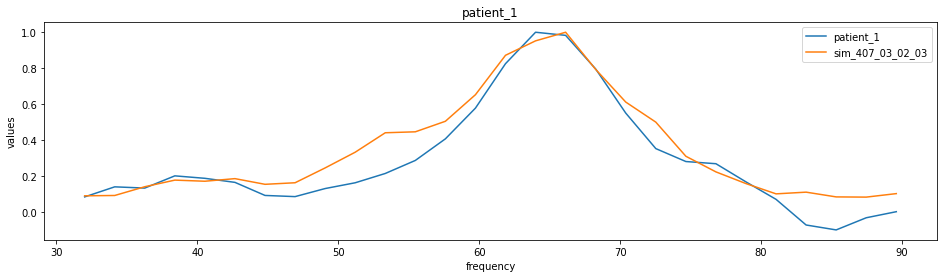

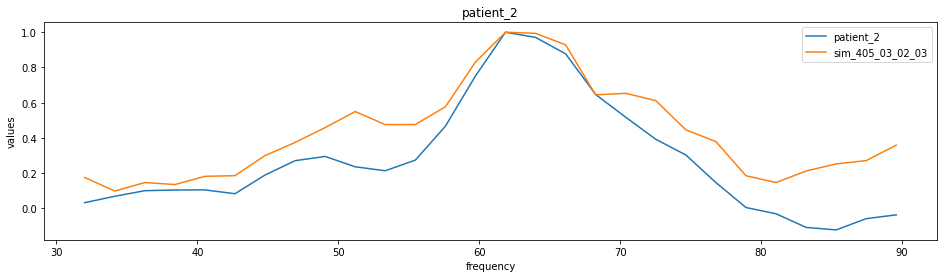

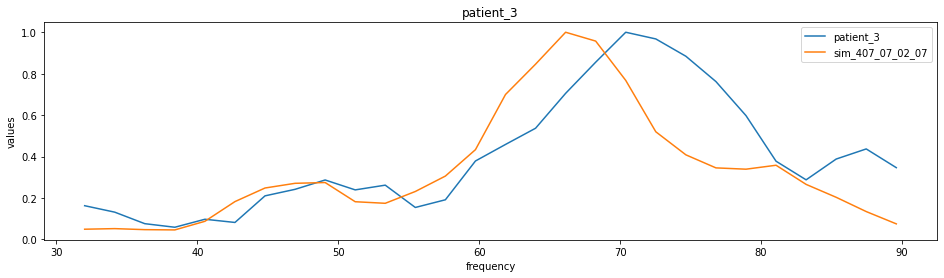

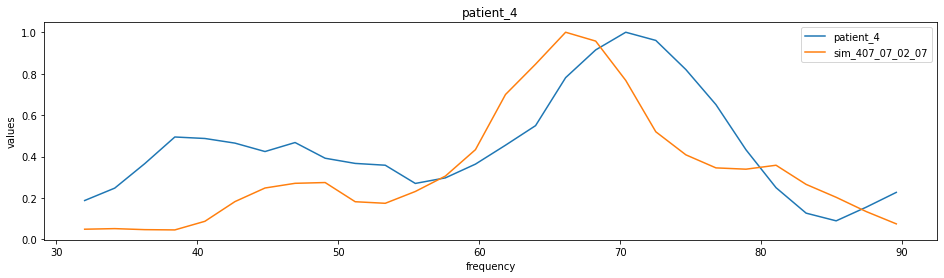

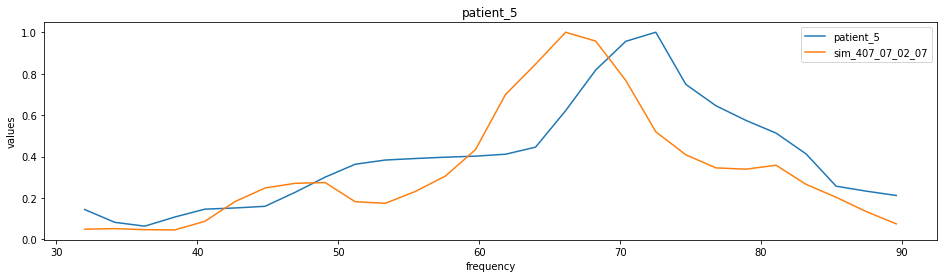

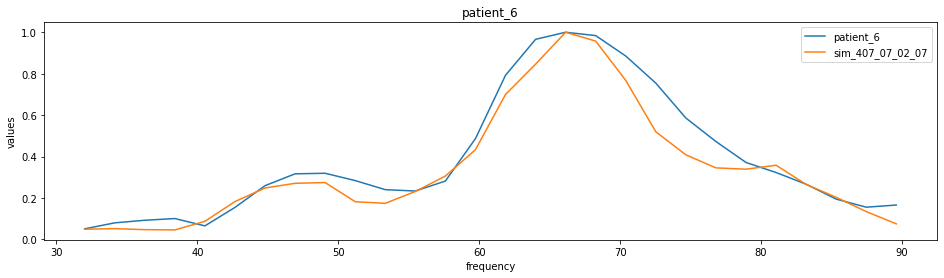

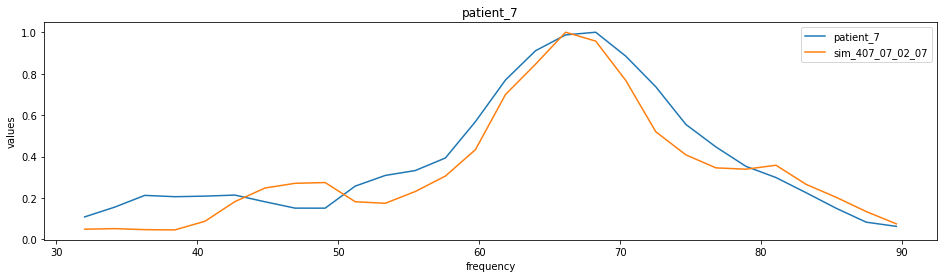

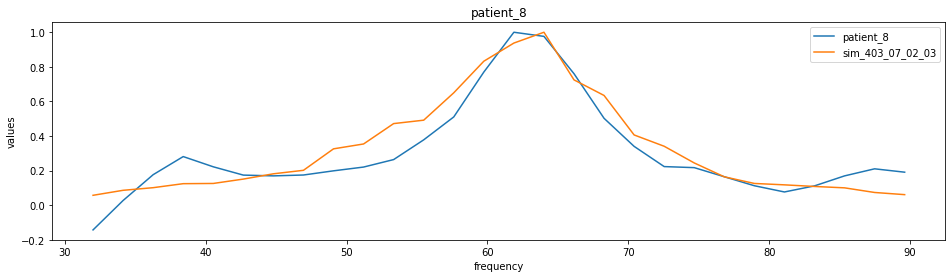

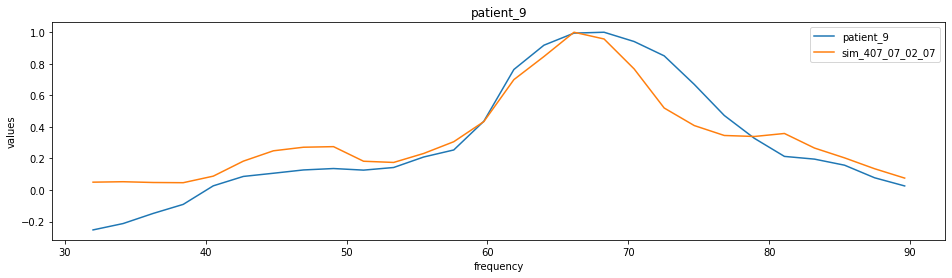

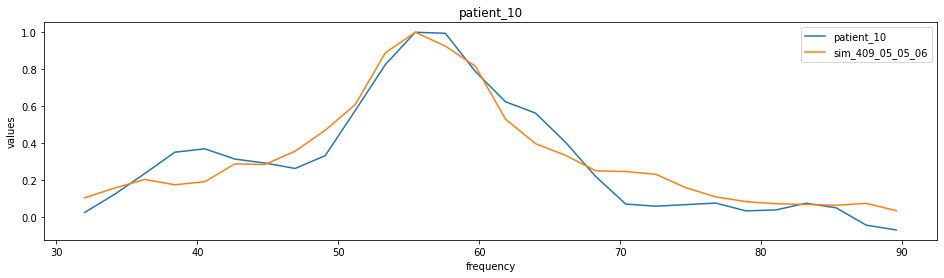

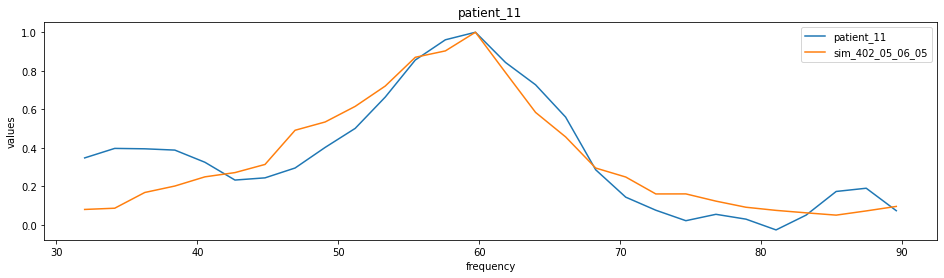

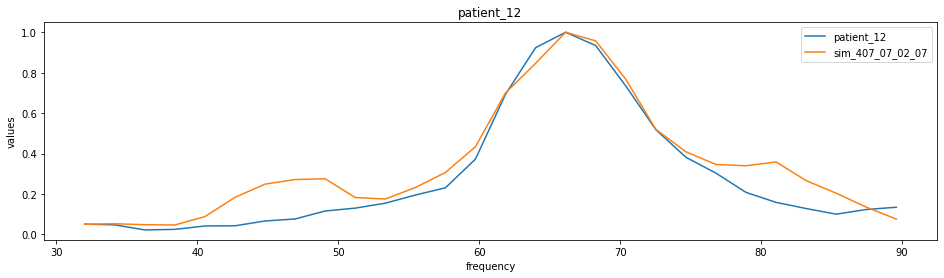

In [5]:
create_viz(result,arrays_dict,sims_dict,freq)